# Introduction to CLASS

#### In our previous introduction, we learned how to visualize and summarize data using Power Spectrum. To make meaningful comparisons, we need to consider a theoretical model.

#### The Power Spectrum is a valuable tool, as k-modes are independent in linear theory. However, obtaining the power spectrum analytically can be challenging, especially when dealing with the transfer function. To tackle this, we calculate the power spectrum using a Boltzmann Solver called 'CLASS.'

#### CLASS is a program that solves a set of Boltzmann equations and linearized Einstein equations, and it incorporates exotic physics. This notebook aims to provide a brief explanation of the basics of CLASS.
#### The first half of this notebook is sourced from https://github.com/lesgourg/class_public.
#### The content of this notebook corresponds to figures 3.7, 3.8, and 4.4 in my thesis.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from classy import Class
import matplotlib
from math import pi

#  Part 1. CMB Angular Powerspectrum

#### Cosmological Parameters: 
#### It sets up a dictionary called common_settings with cosmological parameters. These parameters include the Hubble constant (h), baryon density (omega_b), cold dark matter density (omega_cdm), amplitude of the primordial power spectrum (A_s), and the optical depth to reionization (tau_reio).

In [2]:
common_settings = {# LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm': 0.1201075,
                   'A_s':2.100549e-09,
                   'tau_reio': 0.05430842}

#### l_max_scalars and l_max_tensors: 
#### These variables set the maximum values for l for scalars and tensors. l_max_scalars is set to 3000, and l_max_tensors is set to 600. These values determine the maximum l-values for which the code will calculate power spectra.

In [3]:
l_max_scalars = 3000
l_max_tensors = 600

#### Scalars Mode Calculation: 
#### The code initializes a Class object as M. It sets the cosmological parameters using common_settings, specifies the output (tCl,pCl), modes (s for scalars), disables lensing (lensing is set to 'no'), and provides some additional parameters (n_s, l_max_scalars). 

In [4]:
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9660499,
       'l_max_scalars':l_max_scalars})
M.compute()
cls = M.raw_cl(l_max_scalars)

#### Tensors Mode Calculation: 
#### It sets the same cosmological parameters as scalars but specifies the modes (t for tensors) and other parameters (r, n_t, l_max_tensors). It computes the power spectra for tensors and stores the results in clt.

In [5]:
M.empty() # reset input parameters to default, before passing a new parameter set
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,
       'l_max_tensors':l_max_tensors})
M.compute()
clt = M.raw_cl(l_max_tensors)

#### Combined Calculation:
#### It sets the same cosmological parameters as before but specifies both scalar and tensor modes, enables lensing (lensing is set to 'yes'), and includes additional parameters (l_max_scalars, l_max_tensors). It computes the total power spectra and the lensed power spectra for scalars and tensors, storing the results in cl_tot and cl_lensed.

In [6]:
M.empty() # reset input parameters to default, before passing a new parameter set
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','n_s':0.9660499,'r':0.1,'n_t':0,
       'l_max_scalars':l_max_scalars,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(l_max_scalars)
cl_lensed = M.lensed_cl(l_max_scalars)

#### Now, we want to visualize the CMB power spectrum for different combinations of polarization modes.

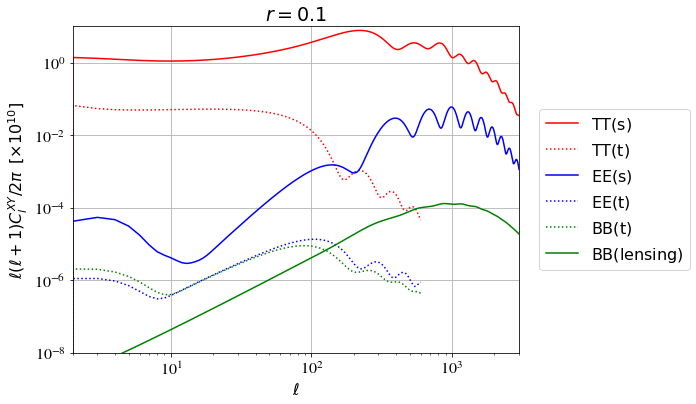

In [7]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

#################
#
# plotting
#
#################
#
plt.xlim([2,l_max_scalars])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./pi
factort = 1.e10*ellt*(ellt+1.)/2./pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

#### Observing this figure, we notice that:

#### 1. Observed maxima and minima in E and T modes are opposite:
#### Although their underlying physical processes are the same, they represent different physical quantities.
#### E-modes primarily arise from the polarization patterns in the CMB resulting from density fluctuations in the scalar perturbations.
#### T-modes represent CMB temperature fluctuations directly and are not related to polarization. They measure how the temperature of the CMB varies across the sky.
#### The E-mode polarization power spectrum shows alternating features due to the polarization patterns generated by density fluctuations, while the T-mode power spectrum, representing CMB temperature fluctuations, typically decreases smoothly with increasing multipole moment.*

#### 2. B-mode polarization is affected by lensing.

#### The primary challenge is to distinguish the primordial B-modes from B-modes generated by other astrophysical processes, such as gravitational lensing. Gravitational lensing can convert some of the E-modes into B-modes. To detect primordial gravitational waves, cosmologists must develop sophisticated techniques to separate the lensing B-modes from the primordial ones.


# Part 2: Transfer Function

#### In cosmology, one of the most challenging aspects of modeling the power spectrum is understanding and calculating the transfer function. The transfer function describes how primordial density fluctuations evolve over cosmic time, influencing the distribution of matter and radiation in the universe.

## The Challenge of Transfer Function Modeling

#### The transfer function modeling is challenging for several reasons:

#### Complex Physics: The behavior of the universe is governed by intricate physical processes, including gravitational interactions, fluid dynamics, and the dynamics of different types of matter and radiation.

#### Nonlinearities: Small initial density perturbations can grow and become nonlinear, requiring more sophisticated modeling approaches. Numerical simulations are often necessary to accurately capture these nonlinear effects.

#### Initial Conditions: Accurate modeling requires precise initial conditions for the universe. However, these conditions are not always known with high certainty, leading to uncertainties in the modeling process.

#### Cosmic Evolution: The universe's expansion and evolution involve multiple components, each of which evolves differently over cosmic time. Modeling their interactions and evolution analytically is a formidable task.

#### Gravitational Effects: The gravitational effects of density perturbations are inherently nonlinear and require sophisticated numerical simulations for accurate modeling.

## However CLASS calculates 'KRASS' on this purpose. 

#### 1. Begin by setting cosmological parameters and CLASS parameters.

In [8]:
common_settings = {# LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.12038,
                   'A_s':2.100549e-09,
                   'n_s': 0.9660499,
                   'tau_reio':0.05430842,
                   # output and precision parameters
                   'output':'tCl,mTk,vTk',
                   'l_max_scalars':5000,
                   'P_k_max_1/Mpc':10.0,
                   'gauge':'newtonian'
                   }

#### 2. Call CLASS to compute fundamental quantities, such as the redshift of recombination (z_rec), which is essential for subsequent calculations.

In [9]:
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['z_rec','tau_rec','conformal_age'])
print (derived.keys())
z_rec = derived['z_rec']
z_rec = int(1000.*z_rec)/1000. # round down at 4 digits after coma
print ('z_rec=',z_rec)

dict_keys(['z_rec', 'tau_rec', 'conformal_age'])
z_rec= 1088.814


#### 3. After this initial step, we call CLASS again to calculate perturbations, specifically at the input value z_rec. Save the total Cl's, which we will use for plotting.

In [10]:
tau_0_minus_tau_rec_hMpc = (derived['conformal_age']-derived['tau_rec'])*M.h()
M.empty() 
M.set(common_settings)
M.set({'z_pk':z_rec})
M.compute()
cl_tot = M.raw_cl(5000)

#### 4. We load the transfer functions at recombination, extracting quantities such as k (wavenumber), Theta0 (intrinsic temperature perturbations), phi, psi, and theta_b.

In [11]:
one_time = M.get_transfer(z_rec)
print (one_time.keys())
k = one_time['k (h/Mpc)']
Theta0 = 0.25*one_time['d_g']
phi = one_time['phi']
psi = one_time['psi']
theta_b = one_time['t_b']

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_cdm', 't_ur', 't_tot'])


#### 5. We calculate related quantities, such as R and the zero point of oscillations. R represents the density ratio of baryonic matter to radiation at recombination.

In [12]:
R = 3./4.*M.Omega_b()/M.Omega_g()/(1+z_rec)  # R = 3/4 * (rho_b/rho_gamma) at z_rec
zero_point = -(1.+R)*psi                     # zero point of oscillations: -(1.+R)*psi
Theta0_amp = max(Theta0.max(),-Theta0.min()) # Theta0 oscillation amplitude (for vertical scale of plot)
print ('At z_rec: R=',R,', Theta0_amp=',Theta0_amp)

At z_rec: R= 0.6228777492869878 , Theta0_amp= 0.9950115236775112


#### 6.  Using interpolation functions, we find the scales associated with Hubble crossing (kh) and sound horizon crossing (ks) by examining the background quantities from CLASS.

In [13]:
# Hubble crossing (k = 2 pi a H), sound horizon crossing (k = 2pi / rs)
background = M.get_background() # load background table
print (background.keys())
background_tau = background['conf. time [Mpc]'] # read confromal times in background table
background_z = background['z'] # read redshift
background_kh = 2.*pi*background['H [1/Mpc]']/(1.+background['z'])/M.h() # read kh = 2pi aH = 2pi H/(1+z) converted to [h/Mpc]
background_ks = 2.*pi/background['comov.snd.hrz.']/M.h() # read ks = 2pi/rs converted to [h/Mpc]
from scipy.interpolate import interp1d
kh_at_tau = interp1d(background_tau,background_kh)
ks_at_tau = interp1d(background_tau,background_ks)
tau_rec = derived['tau_rec']
kh = kh_at_tau(tau_rec)
ks = ks_at_tau(tau_rec)
print ('at tau_rec=',tau_rec,', kh=',kh,', ks=',ks)

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
at tau_rec= 280.487822116805 , kh= 0.04428280139679819 , ks= 0.06415562600874856


#### 7. We then make separate calls to CLASS, each time specifying different temperature contributions, such as intrinsic temperature (TSW), early ISW (eISW), late ISW (lISW), and Doppler effects.


#### TSW (intrinsic temperature + Sachs-Wolfe)

In [14]:
M.empty()           
M.set(common_settings) 
M.set({'temperature contributions':'tsw'})
M.compute()
cl_TSW = M.raw_cl(5000)

#### Early ISW

In [15]:
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'eisw'})
M.compute()
cl_eISW = M.raw_cl(5000)

####  Late ISW 

In [16]:
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'lisw'})
M.compute()

#### Doppler Effect

In [17]:
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'dop'})
M.compute()
cl_Doppler = M.raw_cl(5000)

#### 8. Finally, we create plots to visualize these transfer functions, including the oscillations and specific crossings. Annotations indicate Hubble and sound horizon crossings.


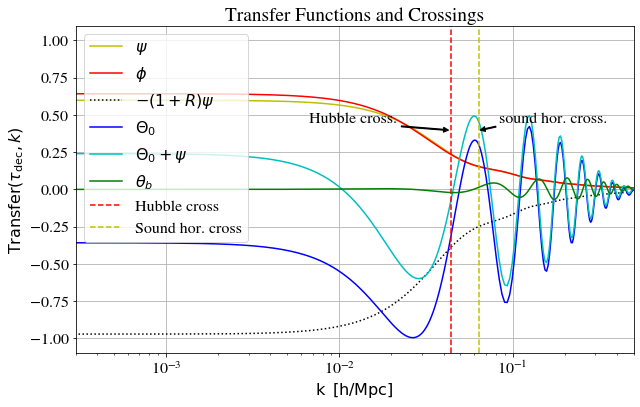

In [18]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.figure(figsize=(10, 6))

# Plot transfer functions
plt.xlim([3.e-4,0.5])
plt.ylim([-1.1*Theta0_amp,1.1*Theta0_amp])
plt.semilogx(k, psi, 'y-', label=r'$\psi$')
plt.semilogx(k, phi, 'r-', label=r'$\phi$')
plt.semilogx(k, zero_point, 'k:', label=r'$-(1+R)\psi$')
plt.semilogx(k, Theta0, 'b-', label=r'$\Theta_0$')
plt.semilogx(k, (Theta0 + psi), 'c', label=r'$\Theta_0+\psi$')
plt.semilogx(k, theta_b, 'g-', label=r'$\theta_b$')

# Vertical lines
plt.axvline(x=kh, color='r', linestyle='--', label='Hubble cross')
plt.axvline(x=ks, color='y', linestyle='--', label='Sound hor. cross')

# Annotations
plt.annotate(r'Hubble cross.',
             xy=(kh, 0.8 * max(Theta0 + psi)),
             xytext=(0.15 * kh, 0.9 * max(Theta0 + psi)),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
plt.annotate(r'sound hor. cross.',
             xy=(ks, 0.8 * max(Theta0 + psi)),
             xytext=(1.3 * ks, 0.9 * max(Theta0 + psi)),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))

# Set labels and title
plt.xlabel(r'$\mathrm{k} \,\,\, \mathrm{[h/Mpc]}$')
plt.ylabel(r'$\mathrm{Transfer}(\tau_\mathrm{dec},k)$')
plt.title('Transfer Functions and Crossings')

# Add legend
plt.legend()
plt.grid()
plt.show()

## Krass, Такой красивый спектр

# Part 3: Matter Powerspectrum
#### Now we are back to Galaxy from CMB.
#### The matter power spectrum contains BAOs that originate from the early universe's sound waves. These BAOs leave characteristic imprints on the distribution of galaxies in the universe. Galaxy surveys use BAO as a 'standard ruler' to measure the universe's expansion history!

#### 1. Here, use the WMAP 9-year best fit Cosmology, as employed in the 高橋さん N-body simulation (https://arxiv.org/abs/1706.01472).

In [19]:
Omega_m = 0.3 # matter density parameter
Omega_b = 0.043 # baryon density parameter
h = 0.7 # reduced Hubble parameter H/100
n_s = 0.97 # Mukh, Zeldovich inflation!
sigma8 = 0.82# oh, A_s, es ist Strebersparameter!
kmax_pk = 50.0
z_max_pk = 2.5
commonsettings = {
'N_ur' :3.046,
'N_ncdm' :0,
'output' :'mPk',
'P_k_max_1/Mpc' :kmax_pk,
'omega_b' :(0.279-0.233) * h**2,
'h' :h,
'n_s' :n_s,
'sigma8' :sigma8,
'omega_cdm' :0.233* h**2,
'Omega_k' :0.0,
'Omega_fld' :0.0, #? I need to go to Heidelberg or imperial!
'Omega_scf' :0.0, #? I need to go to Heidelberg or imperial!
'YHe' :0.24,
'z_max_pk' :z_max_pk,
'write warnings' :'yes' }
Takahashi_linear = Class()
Takahashi_linear.set(commonsettings)
Takahashi_linear.compute()

### 2. Compute 'Liner PowerSpectrum' by different redshifts

In [20]:
kk = np.logspace(-4,np.log10(1),1000)
kk_temp=[]
kk_temp[:]= kk # P(k) in (Mpc/h)**3
Pk_1_temp=[]
Pk_2_temp=[]
Pk_3_temp=[]
Pk_4_temp=[]
for k in kk:
    Pk_1_temp.append(Takahashi_linear.pk(k*h,0.0)*h**3)# function .pk(k,z)
    Pk_2_temp.append(Takahashi_linear.pk(k*h,0.5)*h**3)# function .pk(k,z)
    Pk_3_temp.append(Takahashi_linear.pk(k*h,1.0)*h**3)# function .pk(k,z)
    Pk_4_temp.append(Takahashi_linear.pk(k*h,2.0)*h**3)# function .pk(k,z)
Pk_1= np.array([kk_temp,Pk_1_temp]) #Pk[0] is k and Pk[1] is matter powerspectrum
Pk_2= np.array([kk_temp,Pk_2_temp]) #Pk[0] is k and Pk[1] is matter powerspectrum
Pk_3= np.array([kk_temp,Pk_3_temp]) #Pk[0] is k and Pk[1] is matter powerspectrum
Pk_4= np.array([kk_temp,Pk_4_temp]) #Pk[0] is k and Pk[1] is matter powerspectrum

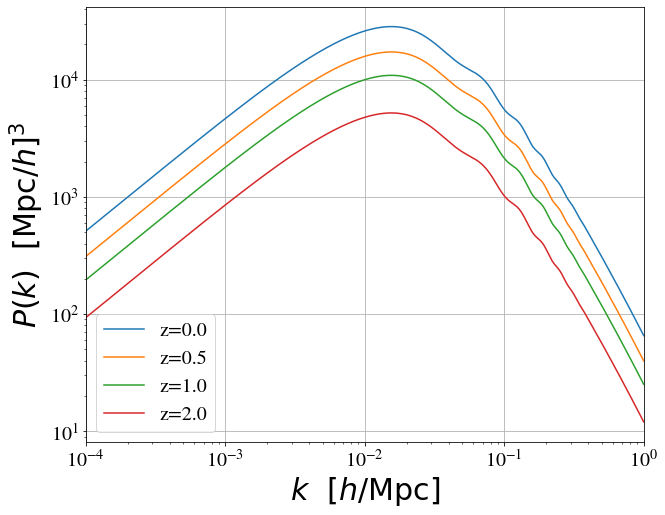

In [21]:
plt.figure(figsize=(10, 8))
plt.xlim(kk[0],kk[-1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=30)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=30)
plt.plot(Pk_1[0],Pk_1[1],label='z=0.0')
plt.plot(Pk_2[0],Pk_2[1],label='z=0.5')
plt.plot(Pk_3[0],Pk_3[1],label='z=1.0')
plt.plot(Pk_4[0],Pk_4[1],label='z=2.0')
plt.grid()
plt.legend(fontsize=20)

#### The amplitude of the power spectrum decreases with going to past!

# Part 4: HaloFit

#### Small scales exhibit more pronounced non-linear world.
#### One approach to account for these non-linear effects in the power spectrum is through N-body simulations.
#### HaloFit is a method that computes the non-linear power spectrum by utilizing correction terms derived from N-body simulations.


In [22]:
Omega_m = 0.279 
Omega_b = 0.043
h = 0.7 
n_s = 0.97
sigma8 = 0.82
nonlinear_model = "Halofit" # nonlinear modelling recipe
kmax_pk = 50.0
z_max_pk = 2.5
commonsettings = {
'N_ur' :3.046,
'N_ncdm' :0,
'output' :'mPk',
'P_k_max_1/Mpc' :kmax_pk,
'omega_b' :(0.279-0.233) * h**2,
'h' :h,
'n_s' :n_s,
'sigma8' :sigma8,
'omega_cdm' :0.279* h**2,
'Omega_k' :0.0,
'Omega_fld' :0.0,
'Omega_scf' :0.0,
'YHe' :0.24,
'z_max_pk' :z_max_pk,
'non linear' :nonlinear_model,
'write warnings' :'yes' }
Takahashi = Class()
Takahashi.set(commonsettings)
Takahashi.compute()
kk = np.logspace(-3,np.log10(30),1000)
kk_temp=[]
kk_temp[:]= kk # P(k) in (Mpc/h)**3
Pk_1_temp=[]
Pk_5_temp=[]
for k in kk:
    Pk_1_temp.append(Takahashi_linear.pk(k*h,0.0)*h**3)
    Pk_5_temp.append(Takahashi.pk(k*h,0.0)*h**3)
Pk_1= np.array([kk_temp,Pk_1_temp])
Pk_5= np.array([kk_temp,Pk_5_temp])

#### Plot this!

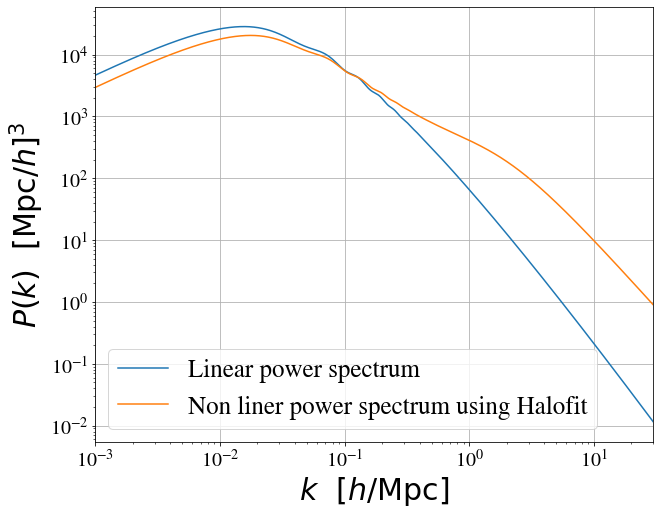

In [23]:
plt.figure(figsize=(10, 8))
plt.xlim(kk[0],kk[-1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=30)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=30)
plt.plot(Pk_1[0],Pk_1[1],label='Linear power spectrum')
plt.plot(Pk_5[0],Pk_5[1],label='Non liner power spectrum using Halofit')
plt.grid()
plt.legend(fontsize=25)
#plt.savefig('Plot/NonLinear_PowerSpectrum.jpg', bbox_inches='tight')

#### Wow small scale(large k) different behaviour!
#### But I guess I see BAO!

# Part 5: Cosmological dependencies!

#### We choose $\Omega_m$ and $\sigma_8$ because they are the most controversial guys besides Hubble one.

In [24]:
# Function to compute power spectrum
def compute_power_spectrum(Omega_m, sigma8):
    # Set up the input parameters
    Omega_b = 0.043  # baryon density parameter
    h = 0.7  # reduced Hubble parameter H/100
    n_s = 0.97  # scalar spectral index
    nonlinear_model = "Halofit"  # nonlinear modeling recipe
    kmax_pk = 50.0
    z_max_pk = 2.5

    # Write down the input dictionary
    commonsettings = {
        'N_ur': 3.046,
        'N_ncdm': 0,
        'output': 'mPk',
        'P_k_max_1/Mpc': kmax_pk,
        'omega_b': Omega_b * h ** 2,
        'h': h,
        'n_s': n_s,
        'sigma8': sigma8,
        'omega_cdm': Omega_m * h ** 2,
        'Omega_k': 0.0,
        'Omega_fld': 0.0,
        'Omega_scf': 0.0,
        'YHe': 0.24,
        'z_max_pk': z_max_pk,
        'non linear': nonlinear_model,
        'write warnings': 'yes'
    }

    # Set up the CLASS object and compute it
    cosmo = Class()
    cosmo.set(commonsettings)
    cosmo.compute()

    # Compute the power spectrum
    kk = np.logspace(-3, np.log10(30), 1000)
    Pk_temp = [cosmo.pk(k * h, 0.0) * h ** 3 for k in kk]

    return np.array([kk, Pk_temp])

In [25]:
Pk_6  = compute_power_spectrum(0.279, 0.82)
Pk_8  = compute_power_spectrum(0.1, 0.82)
Pk_7  = compute_power_spectrum(0.45, 0.82)
Pk_9  = compute_power_spectrum(0.279, 0.5)
Pk_10 = compute_power_spectrum(0.279, 1.1)

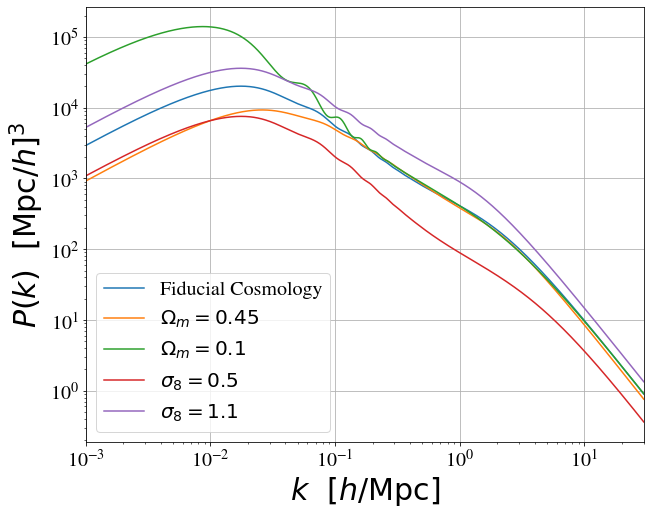

In [26]:
plt.figure(figsize=(10, 8))
plt.xlim(kk[0],kk[-1])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=30)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=30)
plt.plot(Pk_6[0],Pk_6[1],label='Fiducial Cosmology')
plt.plot(Pk_7[0],Pk_7[1],label=f'$\Omega_m=0.45$')
plt.plot(Pk_8[0],Pk_8[1],label=f'$\Omega_m=0.1$')
plt.plot(Pk_9[0],Pk_9[1],label=f'$\sigma_8=0.5$')
plt.plot(Pk_10[0],Pk_10[1],label=f'$\sigma_8=1.1$')
plt.grid()
plt.legend(fontsize=20)

#### Ok it is so natural, higher $\Omega_m$ -> more dark matters -> increas amplitude of power spectrum?
#### In cases with lower $\Omega_m$, the baryon peaks become more pronounced.
#### Ok of course, increasing $\sigma_8$ higher amplitude!

## Part 6: Weaklensing Convergence Matter Power Spctrum

#### The other people aim to identify the correct cosmology based on the characteristics of galaxy shapes!
#### Utilizing the Limber integral, you can obtain the convergence power spectrum, which characterizes the lensing fields.

$$
C_l=\frac{9H^2_0\Omega^2_{m,0}}{4}\int^{\chi_{\text{max}}}_0\text{d}\chi\frac{W^2(\chi)}{a^2(\chi)}P_{3D}\left(\chi,\frac{l}{\Phi_\kappa(\chi)}\right)
$$

#### Here, $\chi$ represents comoving distance.
#### You can calculate $W(\chi)$ from the redshift kernel $q(\chi)$ using the following formula:
$$
W(\chi)=\frac{2a(\chi)}{3H^2_0\Omega_{m,0}\chi}q(\chi)
$$

#### Now, compute the convergence matter power spectrum!

In [27]:
class Cosmology_T17:
    """
    Cosmological Constants for this analysis
    1. It is motivating for the analysis using T17 N-body simulation (arXiv:2304.01187)
    2. Marginalizing \Lambda CDM parameters except \sigma_8 and \Omega_m
    LMAX is from LMAX=3*NSIDE
    """
    NSIDE=128
    #### Because the running time of flask scales lineary with l and maybe I will never use the maps NSIDE=2048
    l  = np.linspace(1,400, 400,dtype=np.int32)
    LMAX = np.max(l)
    """
    Defines a cosmology in היראסאקי. 
    היראסאקי מוס שײנ
    """
    Obfid = 0.279-0.233
    hfid = 0.7
    nsfid = 0.97
    Omfid = 0.279
    sig8fid = 0.82

    """
    Defines source redshift bins
    here I am using the redshift source bin34 of arXiv:2304.01187 which is consistent with map prjecting procedure of T17 arXiv:2304.01187
    """
    # בײֵטםן redshit distribution!
    gz=np.loadtxt("/project/ls-gruen/Takahashi/Rintaro_weak_lesning_maps/source_planes_Takahashi_DESY3_source_BINS_weights.dat",unpack=True)
    zs=gz[0][0:-8]
    g=gz[6][0:-8]
    zmax=np.max(zs)
    zmin=np.min(zs)

In [28]:
class Kappa_Powerspecrum_T17(Cosmology_T17):
    """
    1. Generating the powerpectrum using the Boltzmann solver and getting the matter powerspectrum
    2. Projecting matter powerspectrum in the line of sight using BIN 34 of source redshift disrtibution from arXiv:2304.01187 
    3. It is consisting with the map projectition procedure of T17 simulation (arXiv:2304.01187)
    4. Then I get the weak lensing convergence power spectrum
    """
    def __init__(self):
        """
        Initialise arrays and variables.
        """  
        ### Arrays which is used for Limber Integral
        self.z_range=np.linspace(0,self.zmax,100)
        self.q=np.zeros(len(self.z_range))
        self.w=np.zeros(len(self.z_range))
        self.H=np.zeros(len(self.z_range))
        self.OmM=np.zeros(len(self.z_range))
        self.P=np.zeros(len(self.z_range))
        
        ### Constants which is used for shell-thickness correction
        self.c1  = 9.5171*(0.0001)
        self.c2  = 5.1543*(0.001)
        self.al1 = 1.3063
        self.al2 = 1.1475
        self.al3 = 0.62793
        
        
    def LambdaCDM(self, Omega_m, sigma_8):
        """
        Define the Cosmology using the Boltzmann solver class
        Parameters:
        ----------
        Omega_m : Matter density
        sigma_8 : Present matter fluctuation on 8h^-1 MPC
        
        Notes:
        ----------
        I use the Halofit to calculate the non-linear power spectrum
        
        Returns:
        ----------
        LambdaCDM: LambdaCDM Cosmology
        """
        LambdaCDM = Class()
        h2=self.hfid*self.hfid
        LambdaCDM.set({'omega_b':self.Obfid*h2,'omega_cdm':(self.Omega_m-self.Obfid)*h2,'h':self.hfid,'n_s':self.nsfid,
                        'tau_reio':0.05430842,'N_ur':3.046,'z_max_pk':10.0,'sigma8':self.sigma_8,'non linear':'HALOFIT'})
        LambdaCDM.set({'output':'mPk','P_k_max_1/Mpc':10.})
        # run class
        LambdaCDM.compute()
        return LambdaCDM
    
    def comoving_distance(self,Cosmo,z):
        """
        Calculate the comoving distance using class
        Parameters:
        ----------
        Cosmo: Cosmology from class
        z: redshift
        
        Returns:
        comoving_distance: comoving distance in MPC/h^-1
        """
        return Cosmo.angular_distance(z)*(1.+z)
    
    def Omega_M(self,Cosmo):
        """
        Calculate the matter density using class
        Parameters:
        ----------
        Cosmo: Cosmology from class
        z: redshift
        
        Returns:
        Omega_m: matter density at given redshift z
        """
        return Cosmo.Omega_m()
    
    def Hubble(self, Cosmo, z):
        """
        Calculate the Hubble paramter using class
        Parameters:
        ----------
        Cosmo: Cosmology from class
        z: redshift
        
        Returns:
        Hubble: Hubble parameter at given redshift z
        """
        return Cosmo.Hubble(z)
    
    def P_NL(self,Cosmo, k, z):
        """
        Calculate the non linear 3D matter powerspectrum and make sure it's not going above maximum of k
        Also multiplying the shell thickness effect which is reported in arXiv:2304.01187

        Parameters:
        ----------
        Cosmo: Cosmology from class
        z: redshift
        k: frequency
        
        Returns:
        ----------
        P_NL: non linear powerspectrum in MPc^3/h^-3 which is corrected by the shell thickness effect
        """
        kmax = 10. #from test in last year April
        # we do not compute matter power spectrum at scales smaller than the limit set by kmax
        if k > kmax: 
            return 0
        else:
        # here correcing the shell-thickness effect
            return Cosmo.pk(k, z)
        
    def lensing_kernel(self, Cosmo, z, H_0, Omega0_m):
        """
        Parameters:
        ----------
        z: redshift

        Returns:
        W: lensing kernel mutliplied by comoving distance at the redshift of z
        """
        lensing_kernel=0
        for i in range(len(self.zs)):
            if z<self.zs[i]:
                chi_z = self.comoving_distance(Cosmo,z)
                chi_zs = self.comoving_distance(Cosmo, self.zs[i])
                lensing_kernel+= 3./2. * H_0 * H_0 * Omega0_m * (1.+z) * (chi_zs - chi_z) / chi_zs*self.g[i]
        # here the output is lensing kernel mutliplied by comoving distance at the redshift of z
        ## in order to avoid the division of extremely large number  
        return lensing_kernel
    
        
    def convergence_powerspectrum(self, Cosmo, l):
        """
        Calculate the Limber integral using DES Y3 all source bins
        Parameters:
        ----------
        Omega_m : Matter density
        sigma_8 : Present matter fluctuation on 8h^-1 MPC
        
        Returns:
        ----------
        Pk_2D: convergence powerspectrum
        """
        for i in range(len(self.z_range)):
            self.H[i]=self.Hubble(Cosmo,self.z_range[i])
            self.w[i]=self.comoving_distance(Cosmo,self.z_range[i])
            self.P[i]=self.P_NL(Cosmo,l/self.w[i], self.z_range[i])
            self.q[i]=self.lensing_kernel(Cosmo, self.z_range[i], self.Hubble(Cosmo,0),self.Omega_M(Cosmo))
        Pk_2D = np.trapz((1/self.H)* self.P*self.q**2 ,self.z_range)
        return Pk_2D

    def Cl(self, Omega_m, sigma_8):
        """
        Parameters:
        ----------
        Omega_m : Matter density
        sigma_8 : Present matter fluctuation on 8h^-1 MPC
        
        Note:
        ----------
        output is already corrected by nside resolution effect which is reported in arXiv:2304.01187
        
        Returns:
        ----------
        Cl_2D: convergence powerspectrum which is the array of ([l, Cl])
        l : multipole
        Cl: Convergence power spectrum 
        """
        self.Omega_m = Omega_m
        self.sigma_8 = sigma_8
        Cosmo      = self.LambdaCDM(Omega_m, sigma_8)
        Cl_2D      = np.zeros((len(self.l), 2))
        Cl_2D[:,0] = self.l
        ## here correcting the effect of nside resolution which is reported in arXiv:2304.01187
        NSIDE     = 128
        l_lres    = Cl_2D[:,0]/(1.6*self.NSIDE)
        FRL_fac   = 1/(1.+l_lres**2)
        for i in range(len(self.l)):
            Cl_2D[:,1][i]=self.convergence_powerspectrum(Cosmo, self.l[i])
        Cl_2D[:,1]=Cl_2D[:,1]
        #np.savetxt("/project/ls-gruen/users/r.kanaki/Masterarbeit/Hirosaki_universe/Fisher_Model/Cl_fid-f1z1f1z1.dat",np.c_[Cl_2D[:,0],Cl_2D[:,1]])
        return Cl_2D

In [29]:
# Creating an instance of the Limber class
limber_model = Kappa_Powerspecrum_T17()

# Example usage: Calculating the convergence power spectrum
Omega_m = 0.279
sigma_8 = 0.82
Cl_fid = limber_model.Cl(Omega_m, sigma_8)
Omega_m = 0.1
sigma_8 = 0.82
Cl_Om_01 = limber_model.Cl(Omega_m, sigma_8)
Omega_m = 0.45
sigma_8 = 0.82
Cl_Om_45 = limber_model.Cl(Omega_m, sigma_8)
Omega_m = 0.279
sigma_8 = 0.5
Cl_sig_05 = limber_model.Cl(Omega_m, sigma_8)
Omega_m = 0.279
sigma_8 = 1.1
Cl_sig_11 = limber_model.Cl(Omega_m, sigma_8)

/scratch-local/slurm-job-tmp-6068802/ipykernel_888/2579432471.py:150: RuntimeWarning: divide by zero encountered in true_divide
  self.P[i]=self.P_NL(Cosmo,l/self.w[i], self.z_range[i])


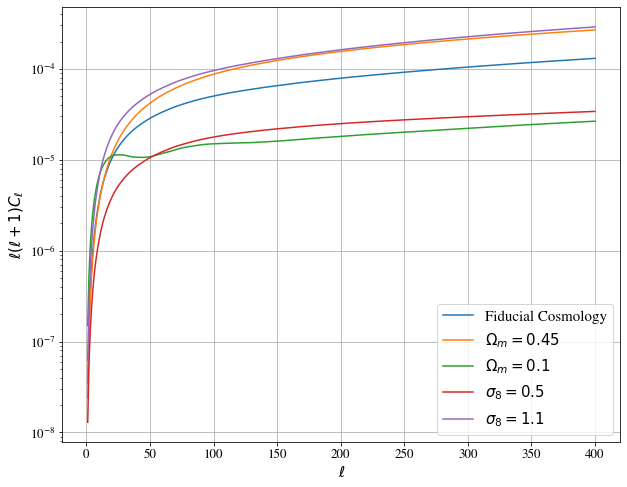

In [30]:
plt.figure(figsize=(10, 8))
plt.yscale('log')
plt.xlabel("$\ell$",fontsize=15)
plt.ylabel("$\ell(\ell+1)C_{\ell}$",fontsize=15)
plt.plot(Cl_fid[:,0],(Cl_fid[:,0]+1)*Cl_fid[:,0]*Cl_fid[:,1],label='Fiducial Cosmology')
plt.plot(Cl_Om_45[:,0],(Cl_Om_45[:,0]+1)*Cl_Om_45[:,0]*Cl_Om_45[:,1],label=f'$\Omega_m=0.45$')
plt.plot(Cl_Om_01[:,0],(Cl_Om_01[:,0]+1)*Cl_Om_01[:,0]*Cl_Om_01[:,1],label=f'$\Omega_m=0.1$')
plt.plot(Cl_sig_05[:,0],(Cl_sig_05[:,0]+1)*Cl_sig_05[:,0]*Cl_sig_05[:,1],label=f'$\sigma_8=0.5$')
plt.plot(Cl_sig_11[:,0],(Cl_sig_11[:,0]+1)*Cl_sig_11[:,0]*Cl_sig_11[:,1],label=f'$\sigma_8=1.1$')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend(fontsize=15)

#### That is what I expexted.
#### BAO features are smoothed out, but what happens at $\Omega_m=0.1$!